In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Generative_Deep_Learning/')

In [119]:
import utils

In [ ]:
from tensorflow.keras import datasets
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [ ]:
import numpy as np

def preprocess(imgs):
  imgs = imgs.astype("float32") / 255.0
  imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values = 0.0)
  # batch size는 그대로 두고, width, height에 각각 2만큼 패딩한다.
  imgs = np.expand_dims(imgs, -1)
  return imgs

In [ ]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [ ]:
# 인코더
encoder_input = layers.Input(
    shape = (32,32,1), name = "encoder_input")
x = layers.Conv2D(32, (3,3), strides = 2, activation = "relu",
                  padding = "same")(encoder_input)

x = layers.Conv2D(64, (3,3), strides = 2, activation = "relu",
                  padding = "same")(x)

x = layers.Conv2D(128, (3,3), strides = 2, activation = "relu",
                  padding = "same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name = "encoder_output")(x)
model = keras.Model(inputs = encoder_input, outputs = encoder_output)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 디코더
# 합성곱 층 대신에 전치 합성곱 층 transposed convolutional layer를 사용
decoder_input = layers.Input(
    shape = (2,), name = "decoder_input"
)

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3,3), strides = 2, activation = "relu", padding = "same"
)(x)
x = layers.Conv2DTranspose(
    64, (3,3), strides = 2, activation = "relu", padding = "same"
)(x)
x = layers.Conv2DTranspose(
    32, (3,3), strides = 2, activation = "relu", padding = "same"
)(x)

decoder_output = layers.Conv2D(
    1,
    (3,3),
    strides = 1,
    activation = "sigmoid",
    padding = "same",
    name = "decoder_output"
)(x)

decoder = keras.Model(decoder_input, decoder_output)

In [ ]:
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 인코더와 디코더를 연결해서 오토인코더를 만든다
autoencoder = keras.Model(encoder_input, decoder(encoder_output))

In [ ]:
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

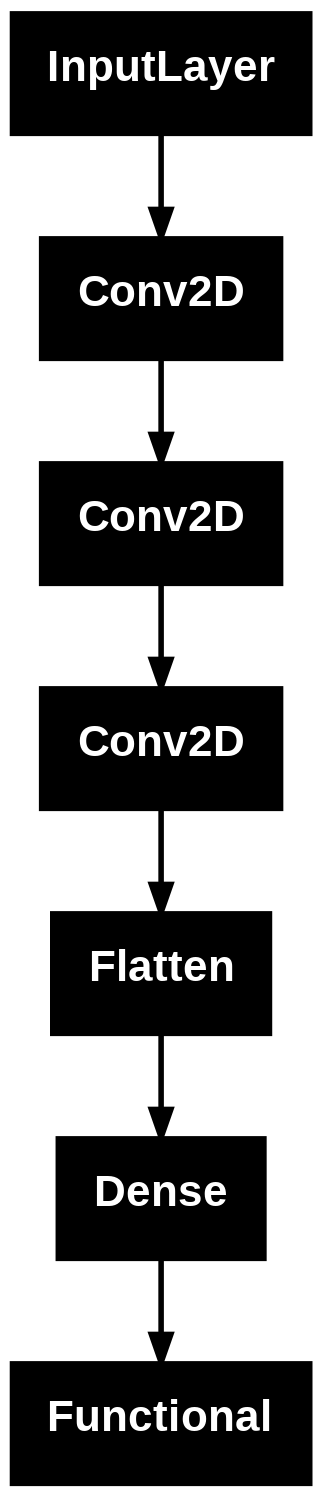

In [ ]:
keras.utils.plot_model(autoencoder,"autoencoder.png")

In [ ]:
#이제 오토인코더를 컴파일하고, 훈련해보자
autoencoder.compile(
    optimizer = "adam",
    loss = "binary_crossentropy"
)

In [ ]:
autoencoder.fit(
    x_train,
    x_train,
    epochs = 5,
    batch_size = 100,
    shuffle = True,
    validation_data = (x_test, x_test),
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.3638 - val_loss: 0.2653
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.2617 - val_loss: 0.2586
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2555 - val_loss: 0.2557
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2534 - val_loss: 0.2546
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2519 - val_loss: 0.2527


In [ ]:
# 이제 이미지를 재구성해보자

In [ ]:
x_train_encoded = model.predict(x_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [ ]:
x_train_encoded[:5000].shape

x_train_encoded_5000 = x_train_encoded[:5000]

In [ ]:
x_train_decoded_5000 = decoder.predict(x_train_encoded_5000)
x_train_decoded_5000.shape

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


(5000, 32, 32, 1)

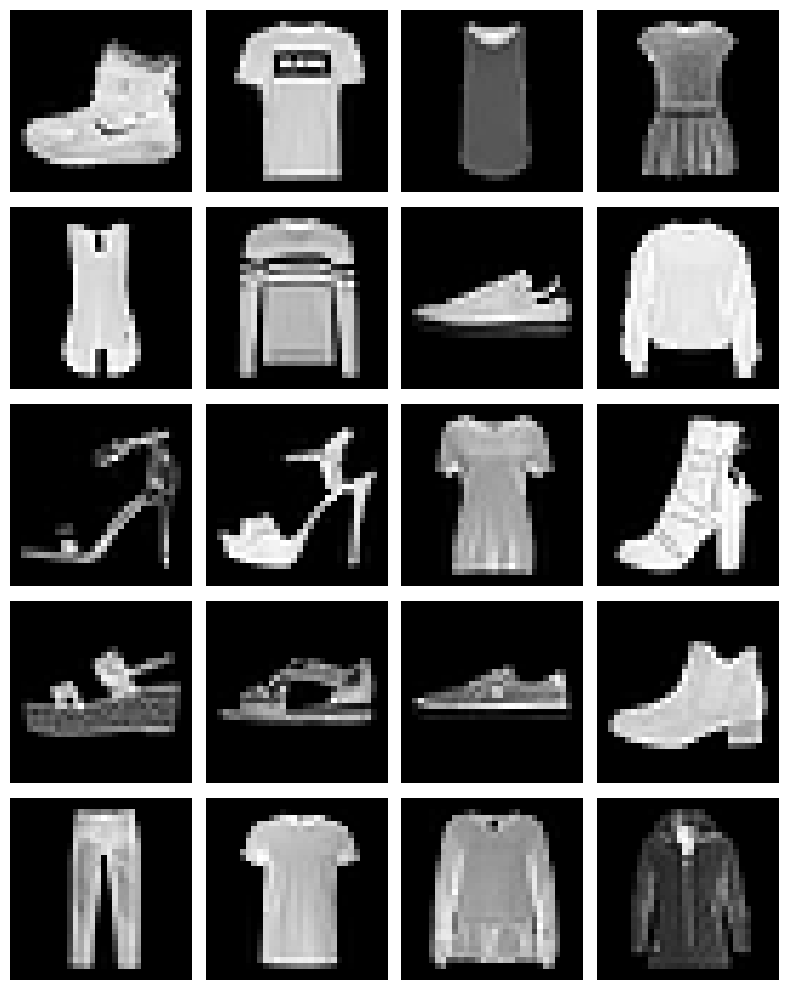

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig,ax = plt.subplots(5,4, figsize= (8,10))
for i in range(20):
  row = i // 4
  col = i % 4
  ax[row, col].imshow(x_train[i], cmap = cm.gray)
  ax[row, col].axis('off')


plt.tight_layout()
plt.show()

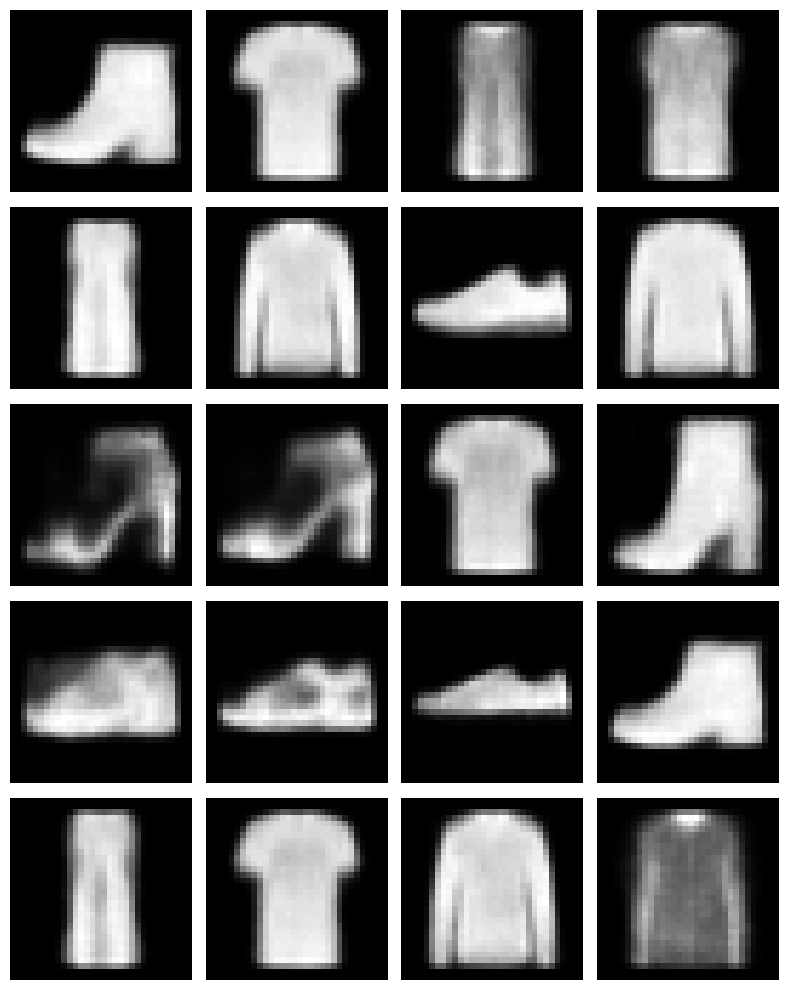

In [ ]:
fig,ax = plt.subplots(5,4, figsize= (8,10))
for i in range(20):
  row = i // 4
  col = i % 4
  ax[row, col].imshow(x_train_decoded_5000[i], cmap = cm.gray)
  ax[row, col].axis('off')


plt.tight_layout()
plt.show()

In [ ]:
x_train_encoded_5000.shape

(5000, 2)

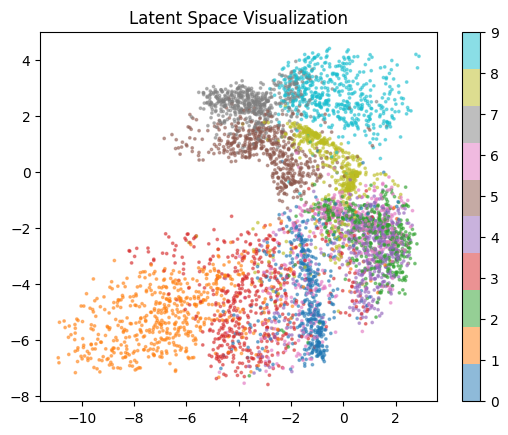

In [ ]:
plt.scatter(x_train_encoded_5000[:,0],
            x_train_encoded_5000[:,1],
            c = y_train[:5000],
            cmap='tab10',
            alpha = 0.5,
            s = 3
)

plt.colorbar()
plt.title("Latent Space Visualization")
plt.show()

In [ ]:
y_test[:5000]

array([9, 2, 1, ..., 9, 0, 7], dtype=uint8)

In [ ]:
mins, maxs = np.min(x_train_encoded_5000, axis = 0), np.max(x_train_encoded_5000, axis = 0)

In [ ]:
sample = np.random.uniform(mins, maxs, size = (18,2))

In [ ]:
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


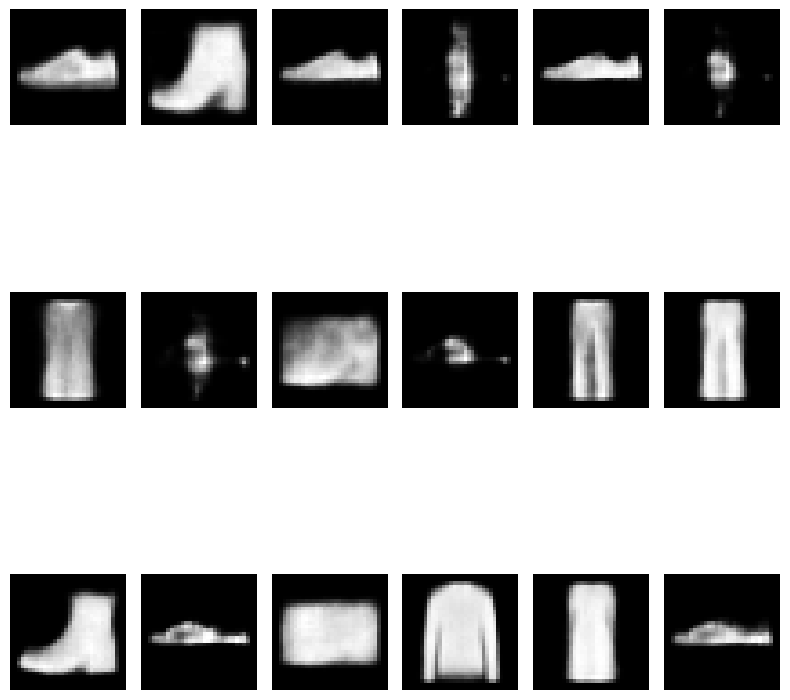

In [ ]:
fig,ax = plt.subplots(3,6, figsize= (8,10))
for i in range(18):
  row = i // 6
  col = i % 6
  ax[row, col].imshow(reconstructions[i], cmap = cm.gray)
  ax[row, col].axis('off')


plt.tight_layout()
plt.show()

# 변이형 오토인코더

In [ ]:
import tensorflow as tf
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(z_log_var * 0.5) * epsilon

In [ ]:
# 인코더를 다시 재정의한다
encoder_input = layers.Input(
    shape = (32,32,1), name = "encoder_input")

x = layers.Conv2D(32, (3,3), strides = 2, activation = "relu",
                  padding = "same")(encoder_input)

x = layers.Conv2D(64, (3,3), strides = 2, activation = "relu",
                  padding = "same")(x)

x = layers.Conv2D(128, (3,3), strides = 2, activation = "relu",
                  padding = "same")(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(2, name = "z_mean")(x)
z_log_var = layers.Dense(2, name = "z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name = "encoder")

In [ ]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 2048)      │          0 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 디코더는 재정의할 필요가 없다
# 다만 변이형 오토인코더의 손실함수는 재정의해야한다.

from tensorflow.keras import models,metrics, losses


class VAE(models.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = metrics.Mean(name = "total_loss")
    self.reconstruction_loss_tracker = metrics.Mean(
        name = "reconstruction_loss"
    )
    self.kl_loss_tracker = metrics.Mean(name = "kl_loss")


  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]

  def call(self, inputs):
    z_mean, z_log_var, z = encoder(inputs)
    reconstruction = decoder(z)
    return z_mean, z_log_var, reconstruction

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, reconstruction = self(data)
      reconstruction_loss = tf.reduce_mean(
          500
          * losses.binary_crossentropy(
              data, reconstruction, axis = (1,2,3)
          )
      )
      kl_loss = tf.reduce_mean(
          tf.reduce_sum(
              -0.5
              * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
              axis = 1,
          )
      )
      total_loss = reconstruction_loss + kl_loss
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)

      return {
          m.name : m.result() for m in self.metrics
      }

In [ ]:
# 이제 훈련을 해보자
vae = VAE(encoder, decoder)
vae.compile(optimizer = 'adam')
vae.fit(
    x_train,
    epochs = 5,
    batch_size = 100
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - kl_loss: 4.3917 - reconstruction_loss: 147.1765 - total_loss: 151.5682
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - kl_loss: 5.0225 - reconstruction_loss: 128.5851 - total_loss: 133.6076
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 5.1421 - reconstruction_loss: 127.3574 - total_loss: 132.4994
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 5.1975 - reconstruction_loss: 126.4361 - total_loss: 131.6337
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 5.2511 - reconstruction_loss: 125.8408 - total_loss: 131.0920


In [ ]:
example_images = x_test[:5000]
example_labels = y_test[:5000]

In [ ]:
# 오토인코더 예측을 만들고 출력
example_z_mean, example_z_log_var, example_recon = vae(example_images)

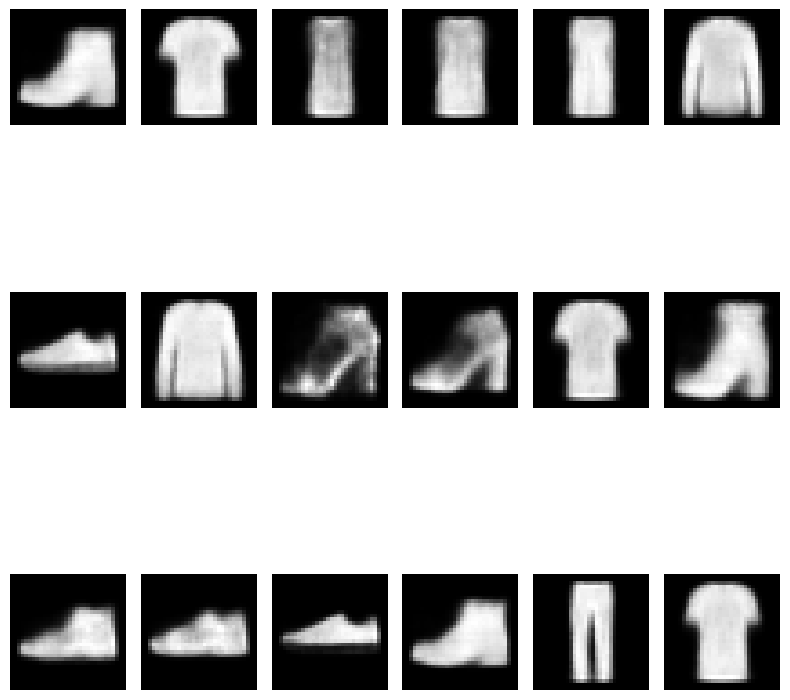

In [ ]:
from notebooks.utils import display

fig,ax = plt.subplots(3,6, figsize= (8,10))
for i in range(18):
  row = i // 6
  col = i % 6
  ax[row, col].imshow(example_recon[i], cmap = cm.gray)
  ax[row, col].axis('off')


plt.tight_layout()
plt.show()

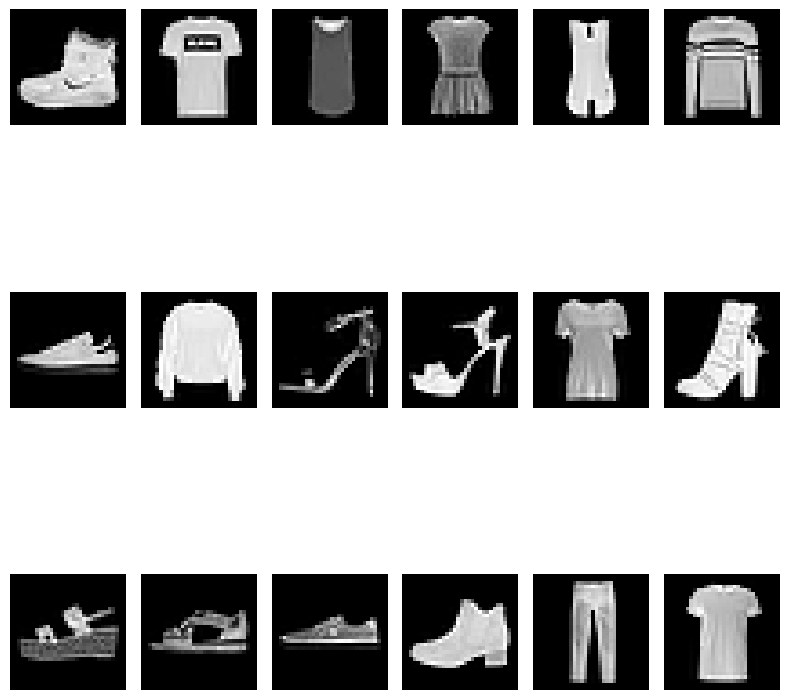

In [ ]:
fig,ax = plt.subplots(3,6, figsize= (8,10))
for i in range(18):
  row = i // 6
  col = i % 6
  ax[row, col].imshow(example_images[i], cmap = cm.gray)
  ax[row, col].axis('off')


plt.tight_layout()
plt.show()

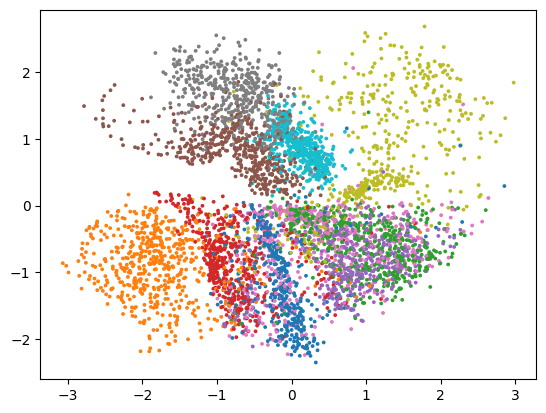

In [ ]:
plt.scatter(example_z_mean[:,0],example_z_mean[:,1],
            s = 3,
            c = y_train[:5000],
            cmap = 'tab10')
plt.show()

In [ ]:
from scipy.stats import norm

In [ ]:
# 표준 정규 분포에서 잠재 공간의 일부 포인트를 샘플링해보자
grid_width, grid_height = (6,3)
z_sample = np.random.normal(size = (grid_width * grid_height, 2))

In [ ]:
# 샘플링된 포인트 디코딩
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [ ]:
# 원본 임베딩과 샘플링된 임베딩을 p값으로 변환하기
p = norm.cdf(example_recon)
p_sample = norm.cdf(z_sample)

array([[[[1.10739556e-07],
         [5.72025893e-09],
         [4.69210846e-07],
         ...,
         [3.86375643e-09],
         [1.00810240e-08],
         [6.36236473e-06]],

        [[4.41527659e-09],
         [9.05101757e-11],
         [2.56597534e-08],
         ...,
         [8.47297454e-10],
         [4.24942498e-10],
         [6.72133240e-07]],

        [[3.53819338e-08],
         [2.58951971e-09],
         [1.14288207e-06],
         ...,
         [1.77768052e-05],
         [6.69743997e-07],
         [8.99272709e-06]],

        ...,

        [[1.02914233e-09],
         [7.49291601e-11],
         [6.84982751e-07],
         ...,
         [1.06473422e-07],
         [1.76755011e-09],
         [1.17197750e-07]],

        [[8.17046608e-09],
         [6.47449649e-10],
         [9.18152125e-07],
         ...,
         [2.06534576e-08],
         [9.86277904e-09],
         [5.55748500e-07]],

        [[1.42368026e-05],
         [5.98744521e-07],
         [1.79322105e-05],
         ...,
 